In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import wrangle as wr

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

from datetime import timedelta, datetime

# Plt defaults
# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=16)
import seaborn as sns; sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
df = wr.wrangle()

In [3]:
df.dtypes

Date                datetime64[ns]
Year                       float64
Month                        int64
Day                          int64
Customer Age               float64
Customer Gender              int64
Country                      int64
State                        int64
Product Category             int64
Sub Category                 int64
Quantity                   float64
Unit Cost                  float64
Unit Price                 float64
Cost                       float64
Revenue                    float64
Year_Month                  object
Margin                     float64
Unit_Margin                float64
dtype: object

In [4]:
pd.to_datetime(df.Date)

0       2015-01-01
1       2015-01-01
2       2015-01-01
3       2015-01-01
4       2015-01-01
           ...    
34861   2016-07-31
34862   2016-07-31
34863   2016-07-31
34864   2016-07-31
34865   2016-07-31
Name: Date, Length: 34866, dtype: datetime64[ns]

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [6]:
df_resampled = df.resample('d')[['Quantity','Revenue']].sum()
df_resampled.head()

,Quantity,Revenue
Date,,
2015-01-01,12.0,9018.0
2015-01-02,10.0,9288.0
2015-01-03,5.0,4776.0
2015-01-04,8.0,6441.0
2015-01-05,4.0,4681.0


In [7]:
df_resampled.shape

(578, 2)

In [8]:
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

289

In [9]:
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

173

In [10]:
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

116

In [11]:
len(df_resampled) == train_size + validate_size + test_size


True

In [12]:
validate_end_index = train_size + validate_size
validate_end_index

462

In [13]:
train = df_resampled[:train_size]


In [14]:
train_size


289

In [15]:
validate = df_resampled[train_size:validate_end_index]


In [16]:
test = df_resampled[validate_end_index:]


In [17]:
train.shape[0], validate.shape[0], test.shape[0]


(289, 173, 116)

In [18]:
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [19]:
print(df_resampled.head(1) == train.head(1))


            Quantity  Revenue
Date                         
2015-01-01      True     True


In [20]:
pd.concat([train.tail(1), validate.head(1)])


,Quantity,Revenue
Date,,
2015-10-16,126.0,32193.0
2015-10-17,119.0,27053.0


In [21]:
pd.concat([validate.tail(1), test.head(1)])


,Quantity,Revenue
Date,,
2016-04-06,224.0,80971.0
2016-04-07,247.0,69181.0


In [22]:
test.head()


,Quantity,Revenue
Date,,
2016-04-07,247.0,69181.0
2016-04-08,217.0,53252.0
2016-04-09,197.0,77365.0
2016-04-10,230.0,66169.0
2016-04-11,163.0,45719.0


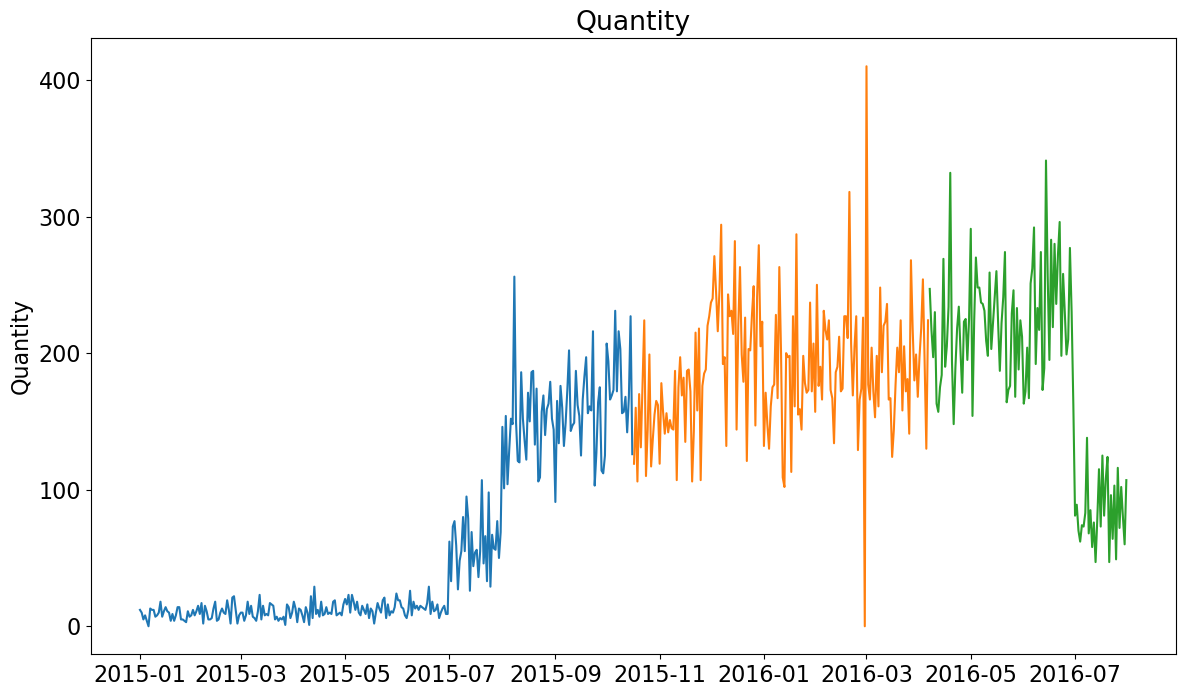

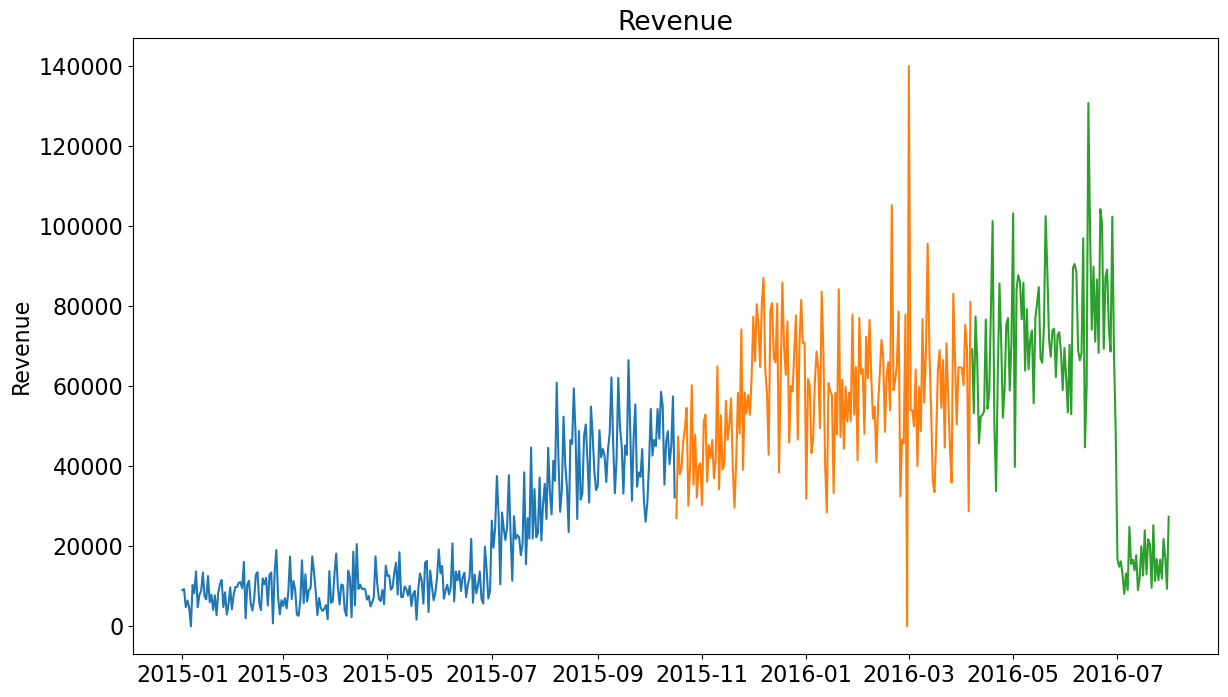

In [23]:
for col in train.columns:
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

In [24]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [25]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [26]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [27]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [28]:
train['Revenue'][-1:][0]


32193.0

In [29]:
last_revenue = train['Revenue'][-1:][0]
last_revenue

32193.0

In [30]:
last_quantity = train['Quantity'][-1:][0]
last_quantity

126.0

In [31]:
yhat_df = pd.DataFrame(
    {'Revenue': [last_revenue],
     'Quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()

,Revenue,Quantity
Date,,
2015-10-17,32193.0,126.0
2015-10-18,32193.0,126.0
2015-10-19,32193.0,126.0
2015-10-20,32193.0,126.0
2015-10-21,32193.0,126.0


In [32]:
from statsmodels.tsa.arima.model import ARIMA

# assuming your time series data is stored in a variable called 'train'
ts = train['Revenue']
model = ARIMA(ts, order=(1,1,1))
results = model.fit()

# you can then use the fitted model to make predictions
forecast = results.forecast(steps=12)

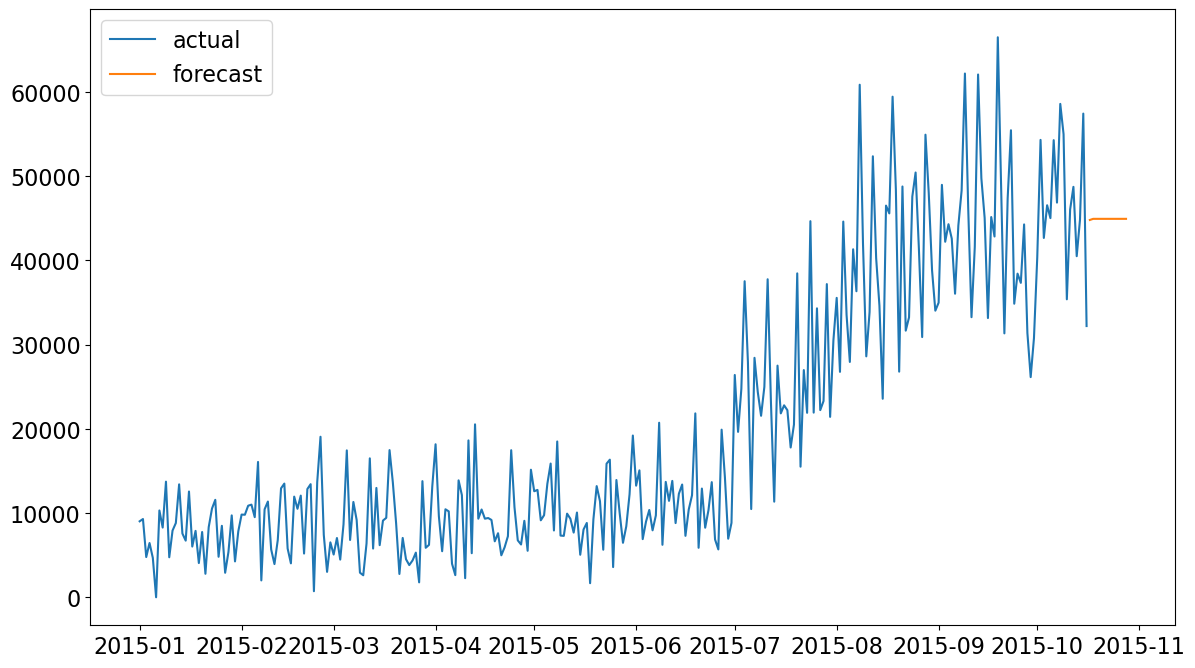

In [33]:
import matplotlib.pyplot as plt

# assuming 'train' contains the original time series data
plt.plot(train.index, train['Revenue'], label='actual')

# plot the predicted values
plt.plot(forecast.index, forecast, label='forecast')

plt.legend()
plt.show()

Quantity -- RMSE: 77


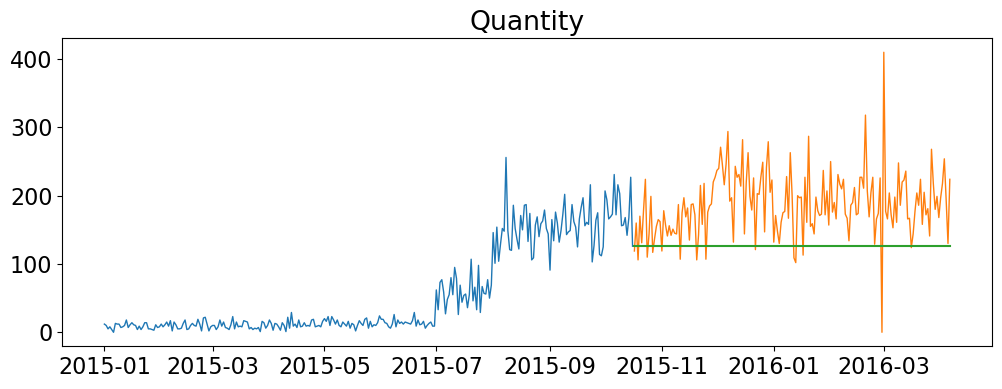

Revenue -- RMSE: 30153


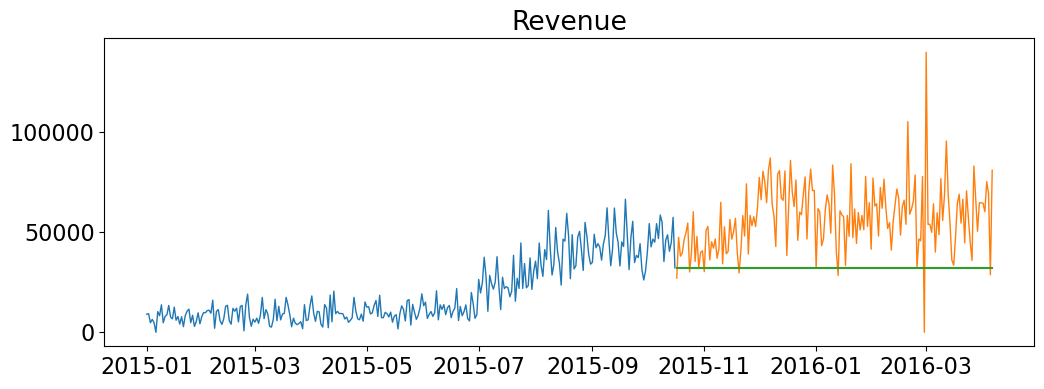

In [34]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [35]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'Revenue': [sales],
                           'Quantity': [quantity]},
                          index=validate.index)
    return yhat_df

In [36]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['Revenue'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['Quantity'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_sales, rolling_quantity)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [37]:
eval_df

,model_type,target_var,rmse
0,previous_year,Quantity,77.0
1,previous_year,Revenue,30153.0
2,4_day_moving_avg,Quantity,52.0
3,4_day_moving_avg,Revenue,21552.0
4,12_day_moving_avg,Quantity,48.0
5,12_day_moving_avg,Revenue,19638.0
6,26_day_moving_avg,Quantity,52.0
7,26_day_moving_avg,Revenue,21824.0
8,52_day_moving_avg,Quantity,54.0
9,52_day_moving_avg,Revenue,21338.0


In [38]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

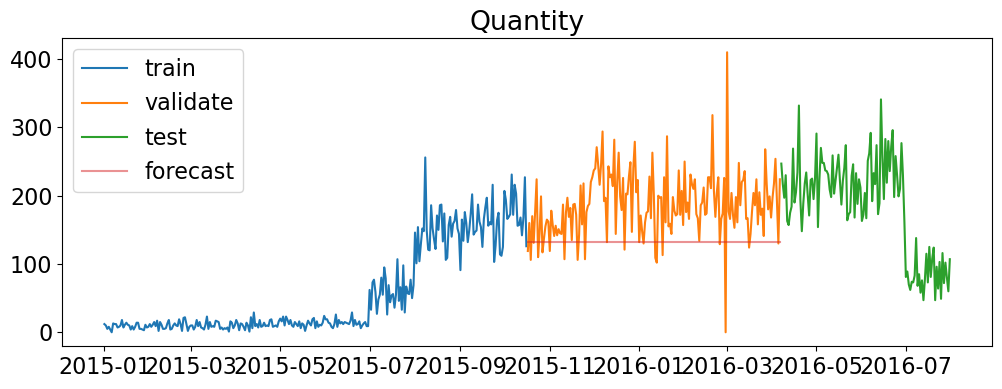

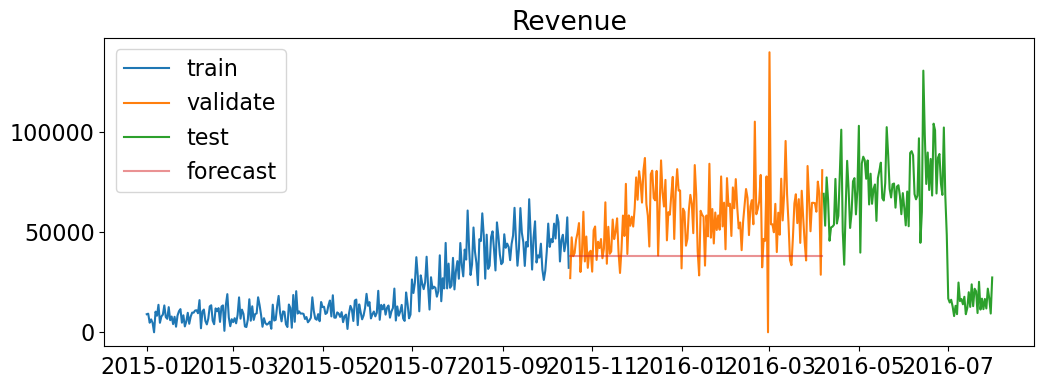

In [39]:
for col in train.columns:
    final_plot(col)

In [40]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
4,12_day_moving_avg,Quantity,48.0
2,4_day_moving_avg,Quantity,52.0
6,26_day_moving_avg,Quantity,52.0
8,52_day_moving_avg,Quantity,54.0
10,104_day_moving_avg,Quantity,73.0
0,previous_year,Quantity,77.0
5,12_day_moving_avg,Revenue,19638.0
9,52_day_moving_avg,Revenue,21338.0
3,4_day_moving_avg,Revenue,21552.0
7,26_day_moving_avg,Revenue,21824.0


In [41]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
4,12_day_moving_avg,Quantity,48.0
5,12_day_moving_avg,Revenue,19638.0


In [42]:
yhat_df 

,Revenue,Quantity
Date,,
2015-10-17,38199.19,132.01
2015-10-18,38199.19,132.01
2015-10-19,38199.19,132.01
2015-10-20,38199.19,132.01
2015-10-21,38199.19,132.01
...,...,...
2016-04-02,38199.19,132.01
2016-04-03,38199.19,132.01
2016-04-04,38199.19,132.01


In [43]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

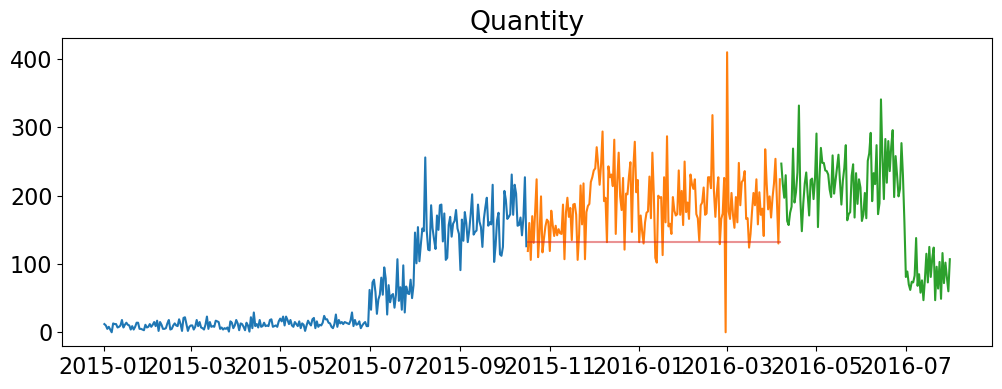

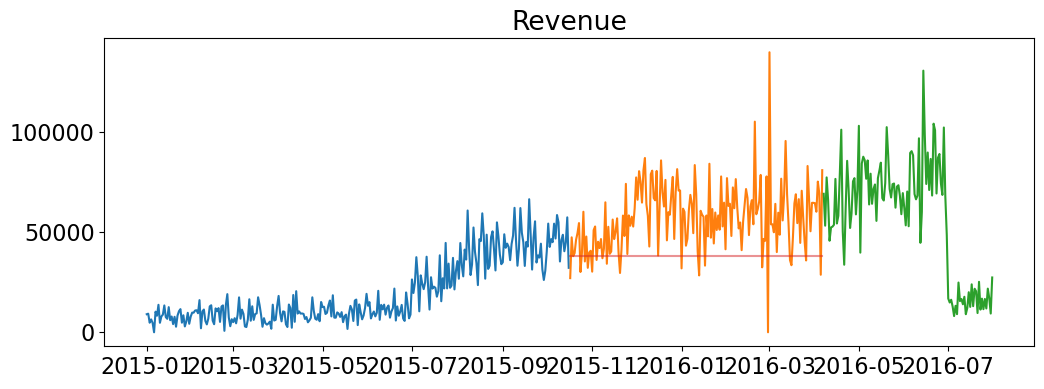

In [44]:
for col in train.columns:
    final_plot(col)

In [45]:
def final_plot1(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    # create a new forecast using the train data
    model = ARIMA(train[target_var], order=(1,1,1))
    results = model.fit()
    forecast = results.forecast(steps=len(test))
    # plot the forecast on top of the train data
    plt.plot(train.index[-1] + pd.date_range(start='1/1/2015', periods=len(forecast), freq='MS'), forecast, alpha=.5)
    plt.title(target_var)
    plt.legend()
    plt.show()

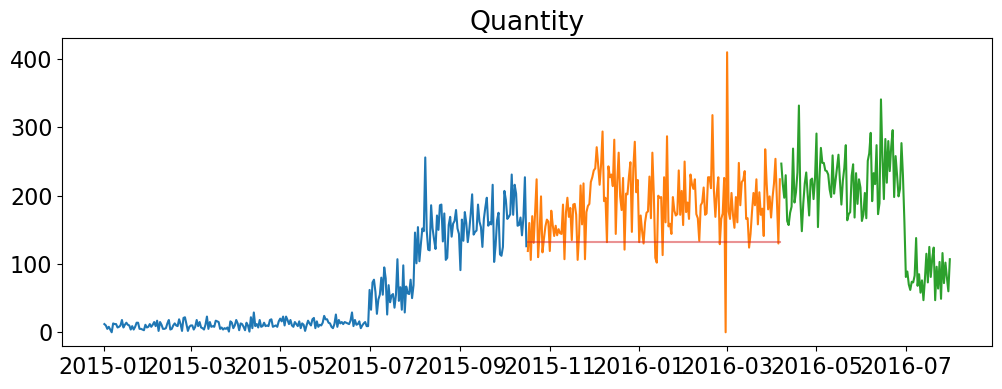

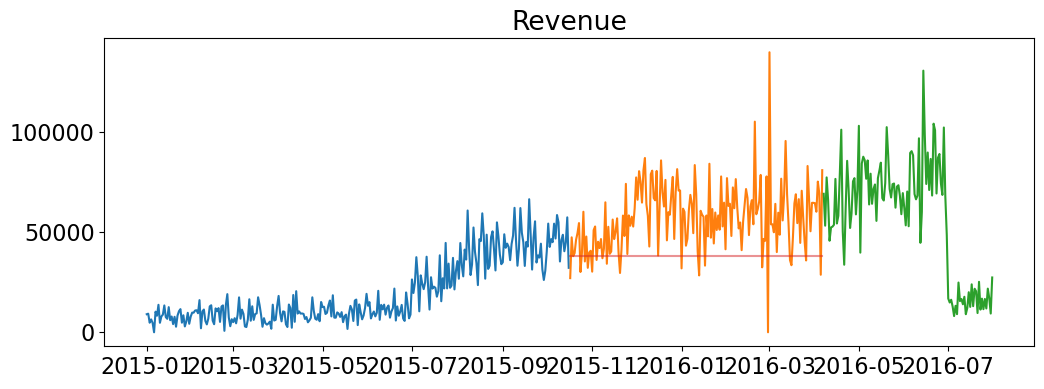

In [46]:
for col in train.columns:
    final_plot(col)


In [47]:
def final_plot2(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    
    # fit ARIMA model on train data
    model = '12_day_moving_avg'
    results = model.fit()
    
    # create forecast for entire time series
    forecast = results.forecast(steps=len(train)+len(validate)+len(test))
    
    # plot forecast on top of train data
    plt.plot(train.index.union(validate.index).union(test.index), forecast, alpha=.5)
    
    plt.title(target_var)
    plt.legend()
    plt.show()

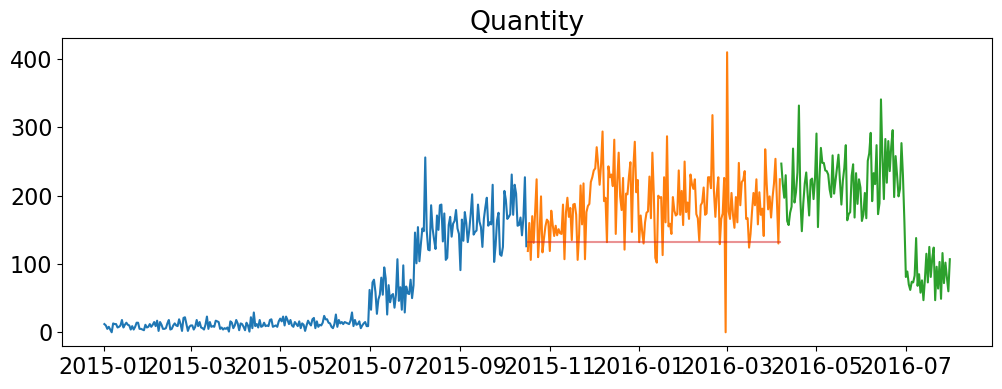

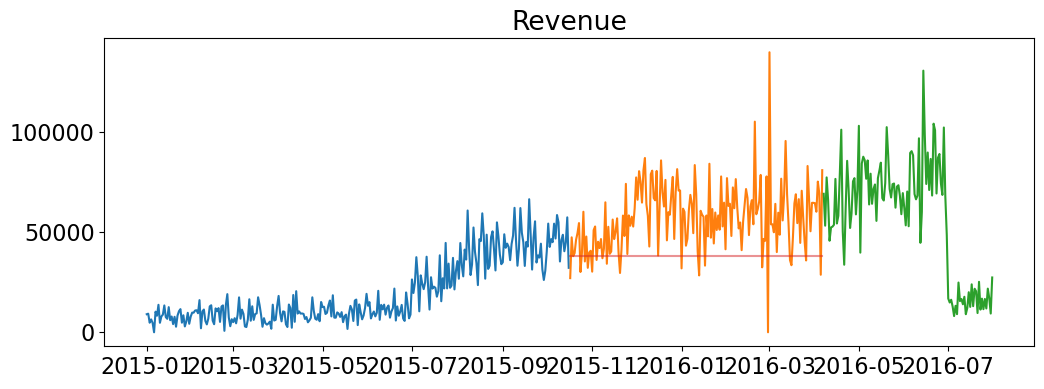

In [48]:
for col in train.columns:
    final_plot(col)


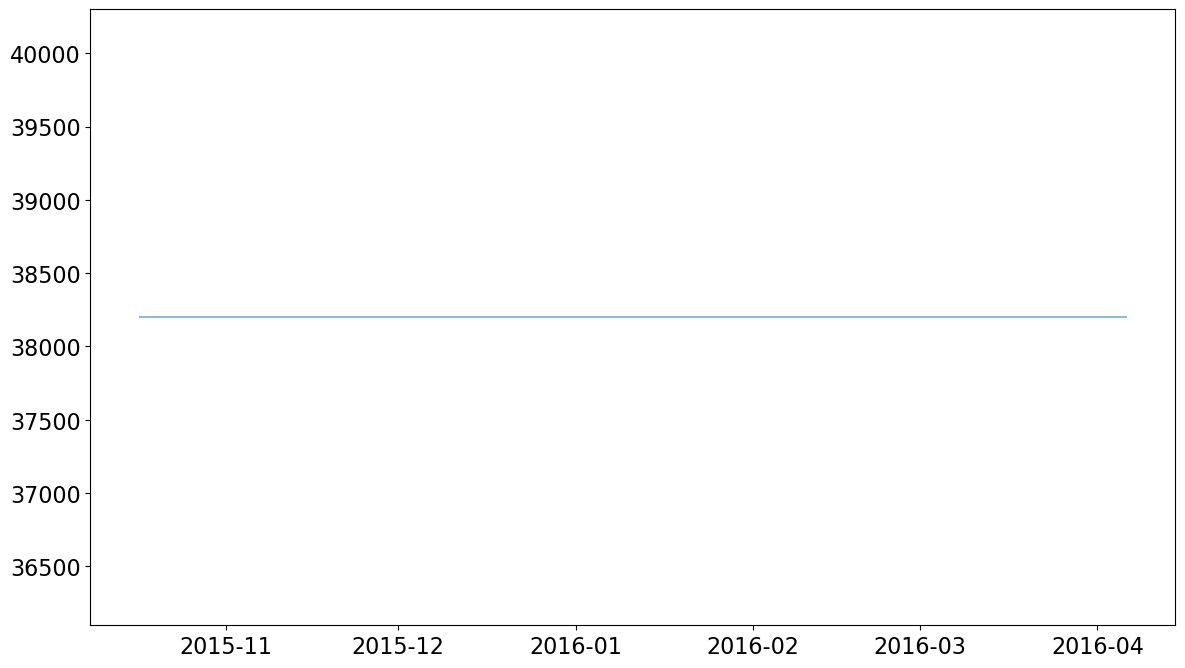

In [49]:
plt.plot(yhat_df.Revenue, alpha=.5, label='forecast')

In [50]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [51]:
yhat_df

,Revenue,Quantity
Date,,
2015-10-17,44740.91,170.10
2015-10-18,44761.66,170.60
2015-10-19,44782.19,171.11
2015-10-20,44802.53,171.61
2015-10-21,44822.65,172.10
...,...,...
2016-04-02,46420.32,227.51
2016-04-03,46424.08,227.73
2016-04-04,46427.81,227.94


In [52]:
col = 'Revenue'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [53]:
yhat_df

,Revenue,Quantity
Date,,
2015-10-17,44740.91,170.10
2015-10-18,44761.66,170.60
2015-10-19,44782.19,171.11
2015-10-20,44802.53,171.61
2015-10-21,44822.65,172.10
...,...,...
2016-04-02,46420.32,227.51
2016-04-03,46424.08,227.73
2016-04-04,46427.81,227.94


Quantity -- RMSE: 50


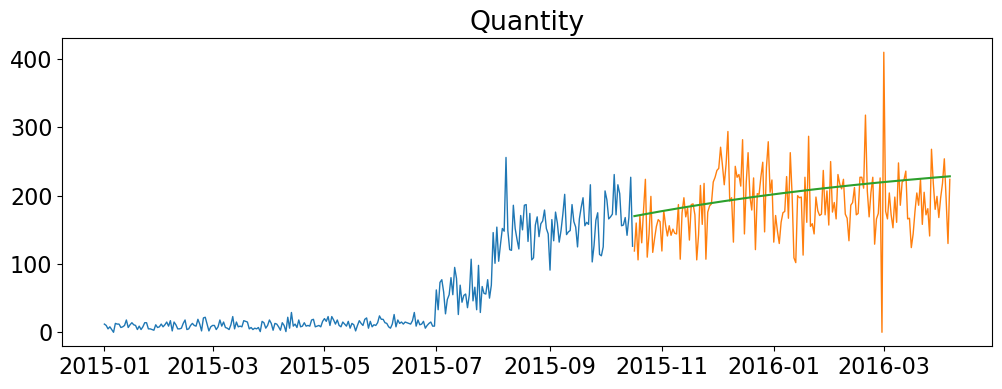

Revenue -- RMSE: 20191


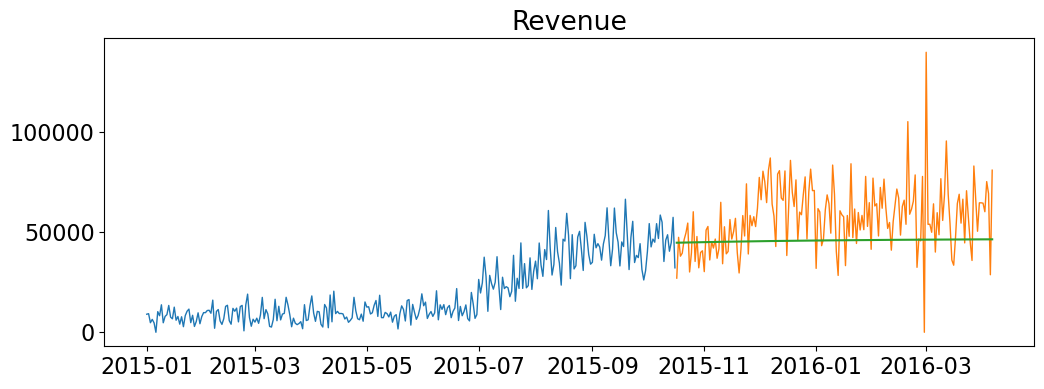

In [54]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [55]:
train = df_resampled[:'2015-10-16']
validate = df_resampled['2015-10-17':'2016-04-06']
test = df_resampled['2016-04-07':]

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(289, 2)
(173, 2)
(116, 2)


,Quantity,Revenue
Date,,
2015-10-12,168.0,48716.0
2015-10-13,142.0,40484.0
2015-10-14,168.0,44826.0
2015-10-15,227.0,57410.0
2015-10-16,126.0,32193.0


In [56]:
train.diff()

,Quantity,Revenue
Date,,
2015-01-01,NaN,NaN
2015-01-02,-2.0,270.0
2015-01-03,-5.0,-4512.0
2015-01-04,3.0,1665.0
2015-01-05,-4.0,-1760.0
...,...,...
2015-10-12,11.0,2688.0
2015-10-13,-26.0,-8232.0
2015-10-14,26.0,4342.0


In [57]:
yhat_df = train[:'2015-10-16'] + train.diff().mean()
yhat_df

,Quantity,Revenue
Date,,
2015-01-01,12.395833,9098.46875
2015-01-02,10.395833,9368.46875
2015-01-03,5.395833,4856.46875
2015-01-04,8.395833,6521.46875
2015-01-05,4.395833,4761.46875
...,...,...
2015-10-12,168.395833,48796.46875
2015-10-13,142.395833,40564.46875
2015-10-14,168.395833,44906.46875


In [58]:
train[:'2015-10-16']

,Quantity,Revenue
Date,,
2015-01-01,12.0,9018.0
2015-01-02,10.0,9288.0
2015-01-03,5.0,4776.0
2015-01-04,8.0,6441.0
2015-01-05,4.0,4681.0
...,...,...
2015-10-12,168.0,48716.0
2015-10-13,142.0,40484.0
2015-10-14,168.0,44826.0


In [59]:
validate = validate[validate.index != '2016-02-29']

In [60]:
train = train[train.index != '2016-02-29']

In [61]:
test = test[test.index != '2016-02-29']

In [62]:
len(validate.index)

172

In [63]:
len(yhat_df.index)

289

ValueError: Found input variables with inconsistent numbers of samples: [172, 289]

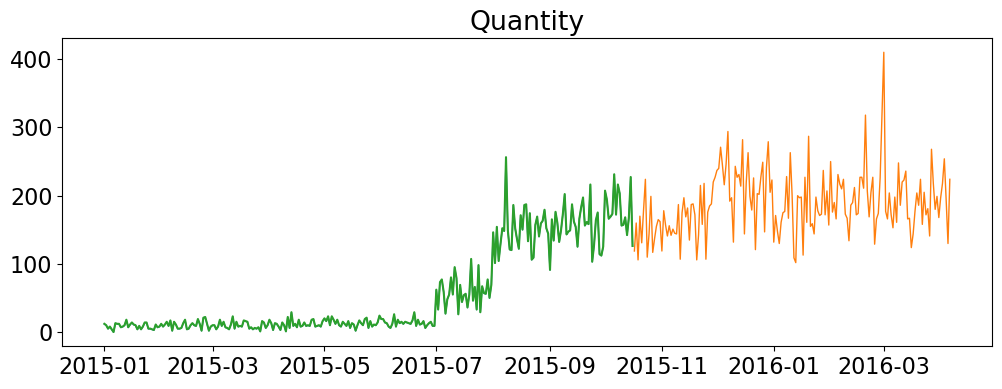

In [64]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = '12_day_moving_av' , 
                            target_var = col)

In [104]:
yhat_df = test + train.diff().mean()

yhat_df.index = test.index + pd.Timedelta('17W')

In [74]:
yhat_df

,Quantity,Revenue
Date,,
2017-04-07 05:49:12,247.395833,69261.46875
2017-04-08 05:49:12,217.395833,53332.46875
2017-04-09 05:49:12,197.395833,77445.46875
2017-04-10 05:49:12,230.395833,66249.46875
2017-04-11 05:49:12,163.395833,45799.46875
...,...,...
2017-07-27 05:49:12,72.395833,11981.46875
2017-07-28 05:49:12,102.395833,21879.46875
2017-07-29 05:49:12,80.395833,17096.46875


In [102]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

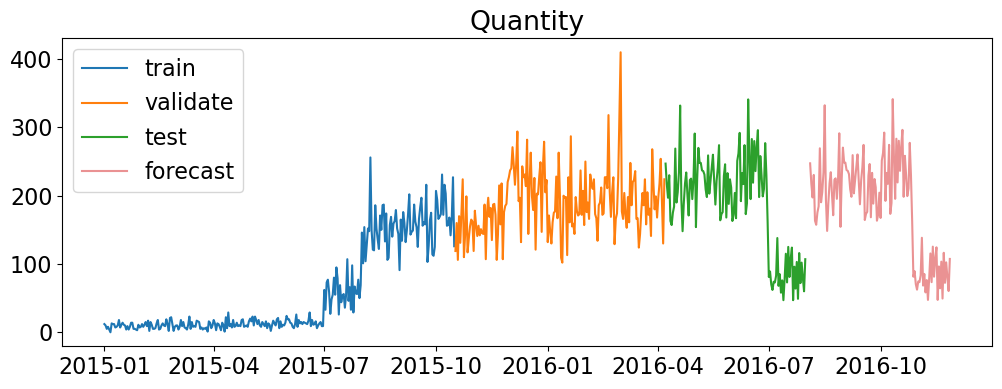

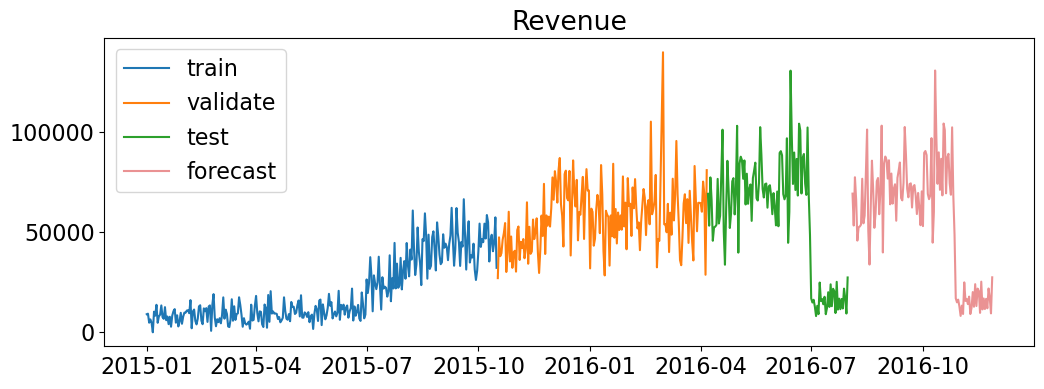

In [105]:
for col in train.columns:
    final_plot(col)

In [107]:
test

,Quantity,Revenue
Date,,
2016-04-07,247.0,69181.0
2016-04-08,217.0,53252.0
2016-04-09,197.0,77365.0
2016-04-10,230.0,66169.0
2016-04-11,163.0,45719.0
...,...,...
2016-07-27,72.0,11901.0
2016-07-28,102.0,21799.0
2016-07-29,80.0,17016.0


In [109]:
yhat_df

,Quantity,Revenue
Date,,
2016-08-04,247.395833,69261.46875
2016-08-05,217.395833,53332.46875
2016-08-06,197.395833,77445.46875
2016-08-07,230.395833,66249.46875
2016-08-08,163.395833,45799.46875
...,...,...
2016-11-23,72.395833,11981.46875
2016-11-24,102.395833,21879.46875
2016-11-25,80.395833,17096.46875
